# Imports

In [1]:
# imports de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

# pour collecte des données
import requests
import dask
from dask import dataframe as dd
from dask import array as da
from dask import delayed
dask.config.set(scheduler='threads')

# pour traitement du language (NLP)
import string
import nltk
nltk.download('wordnet')
from nltk import tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from gensim.models import LdaModel, Word2Vec
from gensim.corpora import Dictionary
from sklearn.model_selection import ParameterGrid
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_texts
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from pyLDAvis import gensim as ldavis_gen
import pyLDAvis

# pour le traitement des images
from PIL import Image
import time, cv2
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import itertools
from matplotlib.image import imread

# pour le Transfer Learning
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Dense, Flatten
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.models import Model

[nltk_data] Downloading package wordnet to /home/slerendu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2023-06-21 12:54:36.955228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 12:54:37.017210: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-21 12:54:37.019292: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file o

# Méthodes du projet

## Méthodes pour le NLP

### Méthodes données

In [2]:
# pour les pie charts, pour afficher les pourcentages et les libellés uniquement avec le taux > limit_perc%
limit_perc = 5
def show_perc(pct):
    """ Affiche le pourcentage de chaque portion si la condition est vérifiée """
    return ('%.1f%%' % pct) if pct > limit_perc else ''

def show_labels(data):
    list = []
    for val, cnt in data.items():
        if (cnt*100/np.sum(data)) > limit_perc :
            list.append(val)
        else:
            list.append('')
    return list

In [3]:
def show_unique_values(df, col, display_pie=True, silent=False):
    """
    Affiche la liste des valeurs uniques contenues dans une colonne
    Affiche le pie chart de ces données également
    """
    temp_val_count = df[col].value_counts(normalize=True).compute()
    df_val_count = temp_val_count.rename_axis("label").to_frame("%")
    df_val_count["%"] = round(df_val_count["%"]*100, 2)
    df_val_count["%_cumul"] = df_val_count["%"].cumsum()
    # afficher la majeur partie des catégories
    sub_display = df_val_count.loc[df_val_count["%_cumul"] <= 85, :]
    
    if silent:
        return sub_display
    
    if len(sub_display) < 5:
        display(df_val_count.head())
    else:
        display(sub_display.head(len(sub_display)))
    if display_pie:
        temp_val_count.plot(kind='pie', autopct=show_perc, labels=show_labels(temp_val_count), label='')
        plt.axis('equal')
        plt.show()
    return sub_display

### Méthodes pour preprocessing

In [4]:
def get_wordnet_pos(word):
    """Return the corresponding character for a word use in the lemmatization
    
    Parameters:
    word (str): a word
    
    Returns:
    str: the corresponding character
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [5]:
def detailled_lemmatizer(sentence):
    """Lemmatize a sentence and return it
    
    Parameters:
    sentence (list(str)): a list of words
    
    Returns:
    (list(str)): a list of lemmatized words
    """
    lemmatizer = WordNetLemmatizer()
    result = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sentence]
    return result

In [6]:
def preprocessing_words(df, col, stem_or_lemma="stem", debug=False):
    """Compute all the basics string tranformations in NLP
    Normalisation, Tokenization, Remove of stopwords, Stemmation or Lemmatization
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    stem_or_lemma (str): choose between stemmation or lemmatization
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words
    """
    result = []    
    # building stopwords list
    stopW = stopwords.words('english')
    stopW.extend(string.punctuation)
    
    for index, row in df.iterrows():
        temp_res = ""
        # normalisation
        temp_res = row[col].lower()
        # tokenization
        temp_res = tokenize.word_tokenize(temp_res)
        # remove stopwords
        temp_res = [word for word in temp_res if word not in stopW]
        
        # stemmation or lemmatization
        if stem_or_lemma == "stem":
            stemmer = PorterStemmer()
            temp_res = [stemmer.stem(elt) for elt in temp_res]
        elif stem_or_lemma == "lemma":
            temp_res = detailled_lemmatizer(temp_res)
            # lemmatizer = WordNetLemmatizer()
            # temp_res = [lemmatizer.lemmatize(elt) for elt in temp_res]
        else:
            print("stem or lemma only")
        
        result.append(temp_res)
    return result

In [7]:
def filter_pos_tag(df, col, tags_to_remove=[], debug=False):
    """Filter words from a list of Part-Of-Speech tags
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    tags_to_remove list(str): a list of POS tag
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    result = []
    if not tags_to_remove:
        print("Aucun filtre n'a été défini.")
        return df[col]
    for index, row in df.iterrows():
        temp_res = pos_tag(row[col])
        temp_res = [x for x in temp_res if x[1] not in tags_to_remove]
        # if debug:
        #     print(temp_res[0])
        result.append([x[0] for x in temp_res])
    return result

In [8]:
def filter_exclude_words(df, col, words_to_exclude=[], debug=False):
    """Filter words from a list of specific words
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    words_to_exclude list(str): a list of words
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    result = []
    if not words_to_exclude:
        print("Aucun mots à exclure.")
        return df[col]
    for index, row in df.iterrows():
        result.append([x for x in row[col] if x not in words_to_exclude])
    return result

In [9]:
def display_wordcloud(corpus, debug=False):
    """Display a WordCloud picture from a corpus
    
    Parameters:
    corpus (dict): a Counter dictionary with the frequency of each words
    debug (bool): show debug elements
    
    Returns:
    
    """
    wordcloud = WordCloud(
            random_state = 42,
            normalize_plurals = False,
            width = 600, 
            height= 300,
            max_words = 100,
            stopwords = [],
            colormap="BrBG")

    wordcloud.generate_from_frequencies(corpus)
    
    fig, ax = plt.subplots(1,1, figsize = (12,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

In [10]:
def natural_language_processing(
    df, col, stem_or_lemma="stem", tags_to_remove=[], words_to_exclude=[],
    max_threshold=999, min_threshold=0, word_cloud=True, debug=False):
    """Compute NLP preprocessing methods
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    stem_or_lemma (str): choose between stemmation or lemmatization
    tags_to_remove list(str): a list of POS tag
    words_to_exclude list(str): a list of words
    max_threshold (int): upper threshold to filter word frequency
    min_threshold (int): lower threshold to filter word frequency
    word_cloud (bool): display WordCloud representation
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    # df = input_df.copy()
    # preprocessing part
    preproc_res = preprocessing_words(df, col, stem_or_lemma=stem_or_lemma, debug=debug)
    df.insert(0, 'preproc_text', preproc_res)
    # if debug:
    #     display(df[[col, 'preproc_text']].head())
    
    # filter by pos tag part
    filtpos_res = filter_pos_tag(df, "preproc_text", tags_to_remove=tags_to_remove, debug=debug)
    df.insert(0, 'filtpos_text', filtpos_res)
    # if debug:
    #     display(df[[col, 'preproc_text', 'filtpos_text']].head())
    
    # filter by excluding words
    filtexcl_words = filter_exclude_words(df, "filtpos_text", words_to_exclude=words_to_exclude, debug=debug)
    df.insert(0, 'filtexcl_words', filtexcl_words)
    
    if debug:
        display(df[[col, 'preproc_text', 'filtpos_text', 'filtexcl_words']].head())
    
    # concatenate all documents into a single corpus
    corpus = df["filtexcl_words"].tolist()
    corpus = [item for sublist in corpus for item in sublist]
    
    word_counts = Counter(corpus)
    print("Il y a un total de", len(word_counts), "mots différents dans tout le corpus.")
    word_counts_threshold = {x: count for x, count in word_counts.items() if count > min_threshold}
    word_counts_threshold = {x: count for x, count in word_counts_threshold.items() if count < max_threshold}
    print("Après filtrage, on garde les mots aparaissant plus de", min_threshold,
          "fois et moins de", max_threshold, "fois. Il reste alors",
          len(word_counts_threshold), "mots différents dans tout le corpus.\n")
    word_counts = Counter(word_counts_threshold)
    # print(word_counts)
    
    if debug:
        print("------------ Top 20 plus communs : ------------")
        display_most_common = [(i, word_counts[i], word_counts[i] / len(corpus) * 100.0) for i, count in word_counts.most_common(20)]
        for elt in display_most_common:
            print(elt)
        print("\n------------ Top 20 moins communs : ------------")
        display_least_common = [(i, word_counts[i], word_counts[i] / len(corpus) * 100.0) for i, count in word_counts.most_common()[-20:]]
        for elt in display_least_common:
            print(elt)
        
    simplified_corpus = word_counts_threshold.keys()
    
    # display wordcloud part
    if word_cloud:
        display_wordcloud(word_counts_threshold, debug=debug)
    
    return simplified_corpus

### Méthodes pour BOW and Word Embedding

In [11]:
def representation_by_tf_idf(corpus):
    """Compute corpus into a tf-idf vectorisation
    
    Parameters:
    corpus (list(list(str)): a list of documents
    
    Returns:
    a matrix of TF-IDF features
    the list of features names
    """
    vect = TfidfVectorizer(ngram_range=(1, 1))
    tfidf_mat = vect.fit_transform(corpus)
    features_names = vect.get_feature_names_out()
    return tfidf_mat, features_names

In [12]:
def representation_by_word2vec(simplified_documents):
    """Compute corpus into a Word2vec vectorisation
    
    Parameters:
    simplified_documents (list(list(str)): a list of documents
    
    Returns:
    the model trained
    """
    model_W2V = Word2Vec(sentences=simplified_documents, vector_size=100, window=5, min_count=300, workers=4)
    model_W2V.train(simplified_documents, total_examples=len(simplified_documents), epochs=50)
    return model_W2V

In [13]:
def display_tsne_plot(model):
    """Display a t-SNE plot from Word Embedding transformation
    
    Parameters:
    model : the Word2vec model trained
    
    Returns:
    
    """
    word_labels = []
    tokens = np.empty((0,100), dtype='f')

    for wrd_score in model.wv.key_to_index:
        wrd_vector = model.wv[wrd_score]
        word_labels.append(wrd_score)
        tokens = np.append(tokens, np.array([wrd_vector]), axis=0)

    tsne_model = TSNE(perplexity=tokens.shape[0]-1, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(word_labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

### Méthodes pour détection

In [14]:
def get_topics(model, feature_names, no_top_words):
    """Display topics detected by model
    
    Parameters:
    model : the model used
    feature_names : names of features from Td-Idf
    no_top_words (int) : nb of words to show
    
    Returns:
    dictionary of words by topic
    """
    word_dict = {};
    for topic_idx, topic in enumerate(model.components_):
        word_dict['Topic' + '{:02d}'.format(topic_idx+1)] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    display(pd.DataFrame(word_dict).head(no_top_words))
    return word_dict

In [15]:
def display_lda(tf, features_names, n_components):
    """Display topics detected by LDA model
    
    Parameters:
    tf : bag of words from Tf-Idf
    feature_names : names of features from Td-Idf
    n_components : nb of topics to detect
    
    Returns:
    
    """
    lda = LatentDirichletAllocation(n_components=n_components, random_state=42)
    lda.fit(tf)
    no_top_words = 5
    word_dict = get_topics(lda, features_names, no_top_words)

In [16]:
def display_nmf(tf, features_names, n_components):
    """Display topics detected by NMF model
    
    Parameters:
    tf : bag of words from Tf-Idf
    feature_names : names of features from Td-Idf
    n_components : nb of topics to detect
    
    Returns:
    
    """
    nmf = NMF(n_components=n_components, random_state=42)
    nmf.fit(tf)
    no_top_words = 5
    get_topics(nmf, features_names, no_top_words)

## Méthodes pour le traitement des images

In [17]:
def extract_descriptors_from_single_photo(photo_name, model_name):
    """preprocessing and detection of descriptors in a single photo
    display the image at each step
    
    Parameters:
    photo_name (str) : path and name of the photo
    model_name (str) : names of model used to detect descriptors
    
    Returns:
    image
    """
    model = get_descriptor_model(model_name)
    
    stem_pic_name = photo_name.split("/")[-1]
    print("Compute", model_name, "model to the picture", stem_pic_name)
    fig, axs = plt.subplots(2, 3, figsize=(15, 12))
    
    image = imread(photo_name)
    axs[0, 0].imshow(image)
    axs[0, 0].set_title("Image brute")
    
    image = cv2.imread(photo_name, cv2.IMREAD_GRAYSCALE)
    axs[0, 1].imshow(image, cmap='gray')
    axs[0, 1].set_title("Image en noir et blanc")
    
    image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)
    axs[1, 0].imshow(image, cmap='gray')
    axs[1, 0].set_title("Image sans bruit")
    
    image = cv2.equalizeHist(image)  # equalize image histogram
    axs[1, 1].imshow(image, cmap='gray')
    axs[1, 1].set_title("Image égalisée")
    
    kp, des = model.detectAndCompute(image, None)
    img=cv2.drawKeypoints(image, kp, image, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # keypoint with size and direction
    axs[1, 2].imshow(img)
    axs[1, 2].set_title("Extraction descripteurs")
    
    # suppression de la case non utilisée
    plt.delaxes(axs[0, 2])
    
    plt.show()
    return image

### Méthodes pour preprocessing

In [18]:
def get_descriptor_model(model_name="SIFT"):
    """return an instance of the model selected
    
    Parameters:
    model_name (str) : names of model used to detect descriptors
    
    Returns:
    instance of the model
    """
    if model_name == "SIFT":
        return cv2.SIFT_create(500)
    elif model_name == "ORB":
        return cv2.ORB_create(500)
    elif model_name == "SURF":
        return cv2.SURF_create()
    else:
        return -1

In [19]:
def extract_descriptors(model_name, list_photos):
    """extraction of the descriptors from an image
    
    Parameters:
    model_name (str) : names of model used to detect descriptors
    list_photos (list()) : 
    
    Returns:
    model_keypoints_by_img : list of descriptors by image
    model_keypoints_all : list of the descriptors
    """
    model = get_descriptor_model(model_name)
    model_keypoints = []
    temps1 = time.time()
    
    for image_num in range(len(list_photos)) :
        # if image_num % 100 == 0 : print(image_num)
        image = cv2.imread("yelp_photos/photos/" + list_photos[image_num] + ".jpg", cv2.IMREAD_GRAYSCALE) # convert in gray
        image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)
        res = cv2.equalizeHist(image) # equalize image histogram
        kp, des = model.detectAndCompute(res, None)
        model_keypoints.append(des)
        
    model_keypoints_by_img = np.asarray(model_keypoints, dtype=object)
    model_keypoints_all    = np.concatenate(model_keypoints_by_img, axis=0)

    print("Nombre de descripteurs : ", model_keypoints_all.shape)
    duration1=time.time()-temps1
    print("Temps de traitement", model_name, "descriptor : ", "%15.2f" % duration1, "secondes")
    
    return model_keypoints_by_img, model_keypoints_all

In [20]:
def cluster_descriptors(model_keypoints_all, nb_categ, meth_nd_clusters="sqrt"):
    """make a clustering of the descriptors
    
    Parameters:
    model_keypoints_all : list of all the descriptors
    nb_categ : nb of categories in the dataset. used id meth_nd_clusters is set to "categ"
    meth_nd_clusters (str) : name of the method to choose the nb of cluster
    
    Returns:
    a kmeans model trained with all the descriptors
    """
    temps1=time.time()
    
    # nb of cluster
    if meth_nd_clusters == "sqrt":
        k = int(round(np.sqrt(len(model_keypoints_all)),0))
    elif meth_nd_clusters == "categ":
        k = nb_categ * 10
    
    print("Nombre de clusters estimés : ", k)
    print("Création de", k, "clusters de descripteurs ...")

    kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=42)
    # kmeans = cluster.KMeans(n_clusters=k, random_state=42)
    kmeans.fit(model_keypoints_all)

    duration1 = time.time() - temps1
    print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")
    
    return kmeans

In [21]:
def build_histogram(trained_kmeans, des, image_num):
    """build a representative histogram of the image
    
    Parameters:
    trained_kmeans : a kmeans model trained with all the descriptors
    des : list of the image descriptors
    image_num (int) : image index
    
    Returns:
    histogram of the image
    """
    res = trained_kmeans.predict(des)
    hist = np.zeros(len(trained_kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

In [22]:
def create_histograms_from_keypoints(model_keypoints_by_img, trained_kmeans):
    """build a representative histogram for each image
    
    Parameters:
    model_keypoints_by_img : list of the descriptors by image
    trained_kmeans : a kmeans model trained with all the descriptors
    
    Returns:
    list of histograms for each image
    """
    temps1 = time.time()
    hist_vectors=[]

    for i, image_desc in enumerate(model_keypoints_by_img) :
        # if i%100 == 0 : print(i)  
        hist = build_histogram(trained_kmeans, image_desc, i) #calculates the histogram
        hist_vectors.append(hist) #histogram is the feature vector

    im_features = np.asarray(hist_vectors)

    duration1 = time.time() - temps1
    print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")
    
    return im_features

In [23]:
def reducing_by_pca(im_features, n_components=0.99):
    """reduce the dimension via a PCA model
    
    Parameters:
    im_features : list of histograms for each image
    n_components (float) : percent of components to keep
    
    Returns:
    features reduced
    """
    print("Dimensions dataset avant réduction PCA : ", im_features.shape)
    pca = decomposition.PCA(n_components=n_components)
    feat_pca= pca.fit_transform(im_features)
    print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
    
    return feat_pca

In [24]:
def get_feature2(l_model, i_img_path):
    l_img = load_img(i_img_path,target_size=(224,224))
    l_x = img_to_array(l_img)
    l_x = np.expand_dims(l_x,axis=0)
    l_x = preprocess_input(l_x)
    l_features = l_model.predict(l_x,verbose=0)
    return l_features

In [25]:
def extract_descriptors_cnn(list_photos):
    """extraction of descriptors by VGG16 model
    
    Parameters:
    list_photos : list of the dataset images
    
    Returns:
    model_keypoints_by_img : list of descriptors by image
    model_keypoints_all : list of the descriptors
    """
    # instance du model VGG16 sans la dernière couche
    model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape= (224, 224, 3))
    x = model_vgg16.output
    model_output = Flatten()(x)
    # on crée une nouvelle dernière couche
    model_for_features = Model(inputs=model_vgg16.input, outputs=model_output)
    
    model_keypoints = []
    temps1 = time.time()
    
    for image_num in range(len(list_photos)) :
        if image_num % 100 == 0 : print(image_num)
        photo_name = "yelp_photos/photos/" + list_photos[image_num] + ".jpg"
        img_feat = get_feature2(model_for_features, photo_name)
        model_keypoints.append(img_feat)
        
    model_keypoints_by_img = np.asarray(model_keypoints, dtype=object)
    model_keypoints_all    = np.concatenate(model_keypoints_by_img, axis=0)

    print("Nombre de descripteurs : ", model_keypoints_all.shape)
    duration1=time.time()-temps1
    print("Temps de traitement CNN VGG16 descriptor : ", "%15.2f" % duration1, "secondes")
    
    return model_keypoints_by_img, model_keypoints_all

### Méthodes pour le t-SNE

In [26]:
def compute_tsne(data, feat_pca):
    """extraction of descriptors by VGG16 model
    
    Parameters:
    data : images dataset
    feat_pca : features reduced by PCA
    
    Returns:
    computed data from TSNE model
    """
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=42)
    X_tsne = tsne.fit_transform(feat_pca)

    df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
    df_tsne["label"] = data["label"]
    
    return df_tsne, X_tsne

In [27]:
def clustering_from_tsne_data(data, df, X_tsne):
    """theorical clustering by kmeans from TSNE data
    
    Parameters:
    data : images dataset
    df : dataframe from TSNE computing
    X_tsne : data from TSNE computing
    
    Returns:
    dataframe from TSNE computing with cluster update
    """
    tsne_clust = cluster.KMeans(n_clusters=5, random_state=42)
    tsne_clust.fit(X_tsne)
    df["cluster"] = tsne_clust.labels_
    print("ARI : ", metrics.adjusted_rand_score(data["label"], tsne_clust.labels_))
    return df

In [28]:
def display_tsne_plot_dbl(df, hue1, hue2):
    """display the 2 t-SNE out of labels and cluster
    
    Parameters:
    df : dataframe from TSNE computing and clustering
    hue1 (str) : column for the left graph
    hue2 (str) : column for the right graph
    
    Returns:
    
    """
    fig, axs = plt.subplots(1, 2, figsize=(16,5))
    sns.scatterplot(
        x="tsne1", y="tsne2", hue=hue1, data=df, legend="brief",
        palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6, ax=axs[0])
    
    sns.scatterplot(
        x="tsne1", y="tsne2", hue=hue2, data=df, legend="brief",
        palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6, ax=axs[1])

    axs[0].set_title('T-SNE clustering réel')
    axs[1].set_title('T-SNE clustering théorique')
    plt.show()

### Méthodes pour la matrice de confusion

In [29]:
def find_corresponding_labels(df, list_labels):
    """compute all combinaisons to find the best match between label and cluster
    
    Parameters:
    df : dataframe from TSNE computing and clustering
    list_labels list(str)) : list of all the labels 
    
    Returns:
    df : the best configuration for the confusion matrix display
    best_res : the best accuracy score
    """
    best_res = ()
    for combinations in list(itertools.permutations(list_labels)):
        for i, name in enumerate(combinations):           
            df.loc[df["cluster"]==i, "cluster_name"] = name
        accuracy_score = metrics.accuracy_score(df["label"], df["cluster_name"])
        if not best_res or accuracy_score > best_res[1]:
            best_res = (combinations, accuracy_score)
            print("Best score so far :", best_res)
    
    # use the best result
    for i, name in enumerate(best_res[0]):
        df.loc[df["cluster"]==i, "cluster_name"] = name
    
    return df, best_res

In [30]:
def display_confusion_matrix(actual_class, predict_class, display_labels=None):
    """display the confusion matrix
    
    Parameters:
    actual_class : serie of the actual classes
    predict_class : serie of the predicted classes
    display_labels list(str)) : list of labels to show in the confusion matrix
    
    Returns:
    
    """
    print("Calcul et affichage de la matrice de confusion")
    # pour calculer la matrice de confusion
    cm = metrics.confusion_matrix(actual_class, predict_class, labels=display_labels)
    cm = cm.T
    
    # pour afficher la matrice de confusion
    displ = metrics.ConfusionMatrixDisplay(cm, display_labels=display_labels)
    displ.plot()
    displ.ax_.xaxis.tick_top()
    displ.ax_.xaxis.set_label_position('top') 
    plt.xlabel('Actual Label')
    plt.ylabel('Predicted Label')
    plt.gcf().axes[0].tick_params()
    plt.gcf().axes[1].tick_params()
    plt.show()

In [31]:
def display_classification_report(actual_class, predict_class, display_labels=None):
    print("Calcul et affichage du rapport de classification")
    clf_report = metrics.classification_report(actual_class, predict_class, target_names=display_labels)
    print(clf_report)

# Volet I : Collecte des données via l'API

Afin de collecter les données via une API, nous avons besoin des différents paramètres nécessaires à l'appel au service web : 
 - la clé de l'API : identifiant unique permettant de s'authentifier au service
 - url : adresse à laquelle on fait l'appel
 - header : paramètres techniques restants pour mener à bien l'appel

In [32]:
# clé de l'API
API_KEY = 'FuGSHa-GIePXqLpg_xrJwhz_DPy7g9sCRm_HAmvUix8ohqLeof8Dy4l4tD3m_pqzsh8tPhjMogzvAwchwxt2Qwr88jh0PRf7O4kwQqzHO8HcNEQyotUad2bM5ONhZHYx'

# url à appeler pour obtenir le GraphQL
url = "https://api.yelp.com/v3/graphql"

# header de l'appel
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/graphql",
}

In [33]:
# initialisation du dataframe recevant les données
businesses = pd.DataFrame(columns=["id", "name", "review_count", "rating", "reviews"])

Pour ce test, nous choisissons de récupérer un échantillon de 200 restaurants. Cependant, nous avons une limitation de taille. Nous ne pouvons recevoir que des paquets de 50 lignes. Nous allons donc boucler pour obtenir nos 200 lignes par pas de 50.  
Dans la requête que nous envoyons au service, nous filtrons sur la catégorie pour avoir uniquement des restaurants et sur la localisation pour avoir des établissements US.

In [34]:
count = 200
limit = 50
for offset in range(0, count, limit):
    query = f'{{\n\
        search(\
            categories: "restaurants", \
            location: "US", \
            offset: {offset}, \
            limit: {limit}\
        ) {{\n\
            business {{\n\
                id\n\
                name\n\
                review_count\n\
                rating\n\
                reviews {{\n\
                    text\n\
                    rating\n\
                }}\n\
            }}\n\
        }}\n\
    }}'
    response = requests.post(url, headers=headers, data=query)
    data = response.json()
    
    # une fois les données récupérées, on les insère à la suite de notre dataframe
    for business in data.get("data", {}).get("search", {}).get("business", []):
        new_row = {
                "id": business.get("id"),
                "name": business.get("name"),
                "review_count": business.get("review_count"),
                "rating": business.get("rating"),
                "reviews": business.get("reviews")
            }
        businesses = pd.concat([businesses, pd.DataFrame([new_row])], ignore_index=True)

In [35]:
print("Nous avons alors un dataframe de", businesses.shape[0], "lignes comme voulu.")

Nous avons alors un dataframe de 200 lignes comme voulu.


Regardons les premières lignes de notre dataframe avec ses colonnes : 

In [36]:
businesses.head()

id                   name review_count  rating   
0  f-m7-hyFzkf0HSEeQ2s-9A  Fog Harbor Fish House         9375     4.5  \
1  oT08T3Vpn1I7jDmrBBRMTw     House of Prime Rib         8570     4.0   
2  WavvLdfdP6g8aZTtbBQHTw             Gary Danko         5864     4.5   
3  n6L5VIGunR51-D55C-eYeQ         Foreign Cinema         5400     4.0   
4  jqEpBbf_qNfWuz_GBkwCjw     Scoma's Restaurant         4388     4.0   

                                             reviews  
0  [{'text': 'Our lunch began with a beautiful sm...  
1  [{'text': 'A visit to HOPR is worth the time a...  
2  [{'text': 'This is an impeccable restaurant, I...  
3  [{'text': 'Had an unbelievable time at Foreign...  
4  [{'text': 'Scoma never fails to disappoint. Be...

Le dataframe créé peut alors être enregistré sous la forme d'un fichier csv.

In [37]:
businesses.to_csv("Lerendu_Stephane_1_csv_052023.csv", sep='\t', encoding='utf-8')

Nous avons pu montrer qu'il était possible d'effectuer de la collecte des données via une API avec les contraintes du cahier des charges.  
Néanmoins, pour la suite de l'étude, nous allons utiliser les fichiers csv de yelp.

# Volet II : Détection des sujets d'insatisfaction dans les commentaires

## Préparation du dataset d'étude

Pour manipuler des dataset volumineux, nous optons pour le framework dask. On charge alors les 2 fichiers csv des reviews et des établissements par son intermédiaire. Cela nous permet d'empêcher de saturer la mémoire de notre machine locale.

In [38]:
reviews = dd.read_json("yelp_dataset/yelp_academic_dataset_review.json",lines = True, encoding = 'utf-8', blocksize="100MB")
businesses = dd.read_json("yelp_dataset/yelp_academic_dataset_business.json",lines = True, encoding = 'utf-8', blocksize="100MB")

A l'aide de dask, nous effectuons des traitements tels que : 
 - la suppression de colonnes
 - filtrage par type d'établissement
 - filtrage par note de reviews; on souhaite des notes de 1 et 2 pour ne travailler qu'avec des mauvaises reviews

In [39]:
# on supprime les colonnes non pertinentes
businesses = businesses.drop(columns=["address", "city", "state", "postal_code", "latitude", "longitude", "attributes", "hours", "is_open", "review_count", "stars"])
reviews = reviews.drop(columns=["user_id", "date", "review_id", "useful", "funny", "cool"])

In [40]:
# on ne garde que les restaurants
restaurant_data = businesses.loc[(businesses["categories"].notnull()) & (businesses["categories"].str.contains("restaurant", case=False)), :]
# on ne garde que les mauvaises reviews, ie, note de 1 et 2
low_rev_data = reviews.loc[(reviews["stars"].notnull()) & (reviews["stars"] < 3), :]

In [41]:
# on supprime la colonne qui n'est plus utile
restaurant_data = restaurant_data.drop(columns=["categories"])

Une fois les divers traitements faits, on bascule le dataframe dask en dataframe pandas pour continuer l'étude.

In [42]:
# on converti le df dask des restaurants en df pandas
restaurant_data = restaurant_data.compute()

In [43]:
# on filtre les reviews pour n'avoir que celles des restaurants
low_rev_data = low_rev_data.loc[low_rev_data["business_id"].isin(restaurant_data["business_id"]), :]

In [44]:
# on converti le df dask des reviews en df pandas
low_rev_data = low_rev_data.compute()

Enfin, on fusionne les données pour obtenir un seul dataset brut.

In [45]:
# merge des 2 df pour avoir uniquement les reviews inf. à 3 des restaurants
raw_data = pd.merge(restaurant_data, low_rev_data, on="business_id", how='inner')

In [46]:
print("On obtient alors un dataset brut de", raw_data.shape[0], "lignes de reviews pour", raw_data.shape[1], "colonnes.")

On obtient alors un dataset brut de 971722 lignes de reviews pour 4 colonnes.


On choisit cependant de prendre une fraction de ces données pour gagner en temps de calcul.

In [47]:
# on en prend une fraction pour les performances
data_words = raw_data.sample(frac=0.004, random_state=42)

In [48]:
print("On obtient alors un dataset d'étude de", data_words.shape[0], "lignes de reviews pour", data_words.shape[1], "colonnes.")

On obtient alors un dataset d'étude de 3887 lignes de reviews pour 4 colonnes.


In [49]:
rev_per_biz = data_words.groupby("business_id").count()["stars"]
print("Cela correspond à", rev_per_biz.shape[0], "lignes de restaurant.")

Cela correspond à 3404 lignes de restaurant.


In [50]:
data_words.head()

business_id                                  name  stars   
882258  TyYpzJzeKWtyMdPFtPRUEg                          Prince Pizza      1  \
642407  LCMpkeQWHdCbuX0Nlkmeow                       Jack in the Box      1   
831418  AZ42H2kk4JUiskC9NPoUjw  Hobnobber's Variety Bar & Restaurant      1   
452134  0CeoONLXqseUxPdGerefOQ                          Mexican Post      1   
921422  QYEiZzwL8I4-q_3U0bq0eQ                 The Nutrition Factory      1   

                                                     text  
882258  This place was horrible! They got my entire or...  
642407  I have no idea why I bother. It's the closest ...  
831418  After reading glowing reviews of staff and foo...  
452134  Horrible Ground beef/bean Chimichanga. There w...  
921422  They are usually awesome but picked up a kale ...

## Traitements de preprocessing

En premier lieu, nous devons effectuer un prerpocessing sur nos données textes : 
 - normalisation : mettre tous les mots en minuscule
 - tokenization : chaque phrase devient une liste de mots
 - stop words : suppression des mots non essentiel tels que les pronoms, déterminants...
 - lemmatisation : réduire les mots à leur forme canonique
 - Part-Of-Speech (POS) : suppression des mots selon leur nature telle que adjectifs, adverbes, modaux...
 - mots non pertinents : selon notre étude, certains mots ne sont pas pertinents tels que "restaurant", "like", "go"...
 - fréquence : si le mot est trop présent ou pas assez, il ne sera pas utile pour faire ressortir un sujet en particulier

Il y a un total de 9382 mots différents dans tout le corpus.
Après filtrage, on garde les mots aparaissant plus de 200 fois et moins de 1000 fois. Il reste alors 114 mots différents dans tout le corpus.



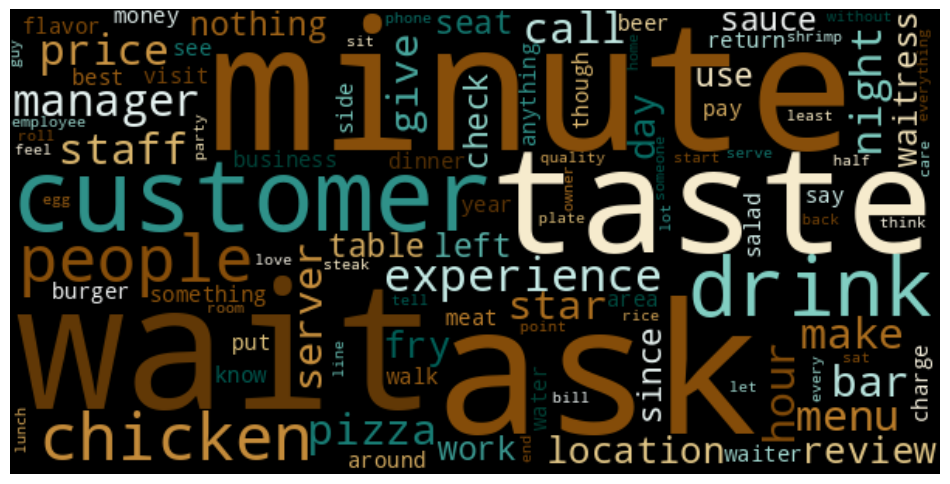

In [51]:
# ponctuation restante dans le top 10
words_to_exclude = [
    "``", "''", ".", "..", "...", "....", "....."
]
# mots à supprimer
words_to_exclude += [
    "get", "like", "go", "come", "take", "try", "told", "look", "another", "way",
    "restaurant", "thing", "wife", "husband", "u", "meal", "friend", "eat"
]

corpus = natural_language_processing(
    data_words, "text", stem_or_lemma="lemma", words_to_exclude=words_to_exclude,
    tags_to_remove=["JJ", "RB", "MD", "POS", "CD", ":", "PRP", "VBP"],
    max_threshold=1000, min_threshold=200, debug=False)

On peut remarque sur ce nuage de mots différents mots qui ressortent : 
 - minute, wait, hour : en rapport avec le temps d'attente
 - ask, customer, people : en rapport avec la qualité du service
 - taste, drink, chiken : en rapport avec la nourriture elle-même
 
Cela nous donne une bonne première idée des thèmes qui ressortirons à la fin de notre étude.

## Traitements de Bag of Words et Word Embedding

Cependant, nos algorithmes ne peuvent traiter des mots. Ils leur faut des nombres. C’est pourquoi, nous allons maintenant traduire ces mots en vecteur.  
Nous avons utilisé 2 méthodes :
 - le Bag of Words avec Tf-Idf : on effectue un comptage des occurrences de chaque mot par reviews en le pondérant par le nombre total d'occurrence dans le corpus entier. L'inconvénient est que l'on perd le sens et l’ordre des mots
 - le Word Embedding avec Word2vec : permet une réduction de dimension et considère le mot dans son contexte.

In [52]:
# traitement de bow tf-idf pour les traitements suivants
tfidf_mat, features_names = representation_by_tf_idf(corpus)

In [53]:
# préparation des données pour l'optimisation
documents = data_words["filtexcl_words"].tolist()
simplified_documents = []
for doc in documents:
    simplified_documents.append([x for x in doc if x in corpus])
dictionary = Dictionary(simplified_documents)
corpus_gensim = [dictionary.doc2bow(doc) for doc in simplified_documents]    

In [54]:
model_W2V = representation_by_word2vec(simplified_documents)

Le modèle Word2vec nous permet également de représenter graphiquement le résultat.

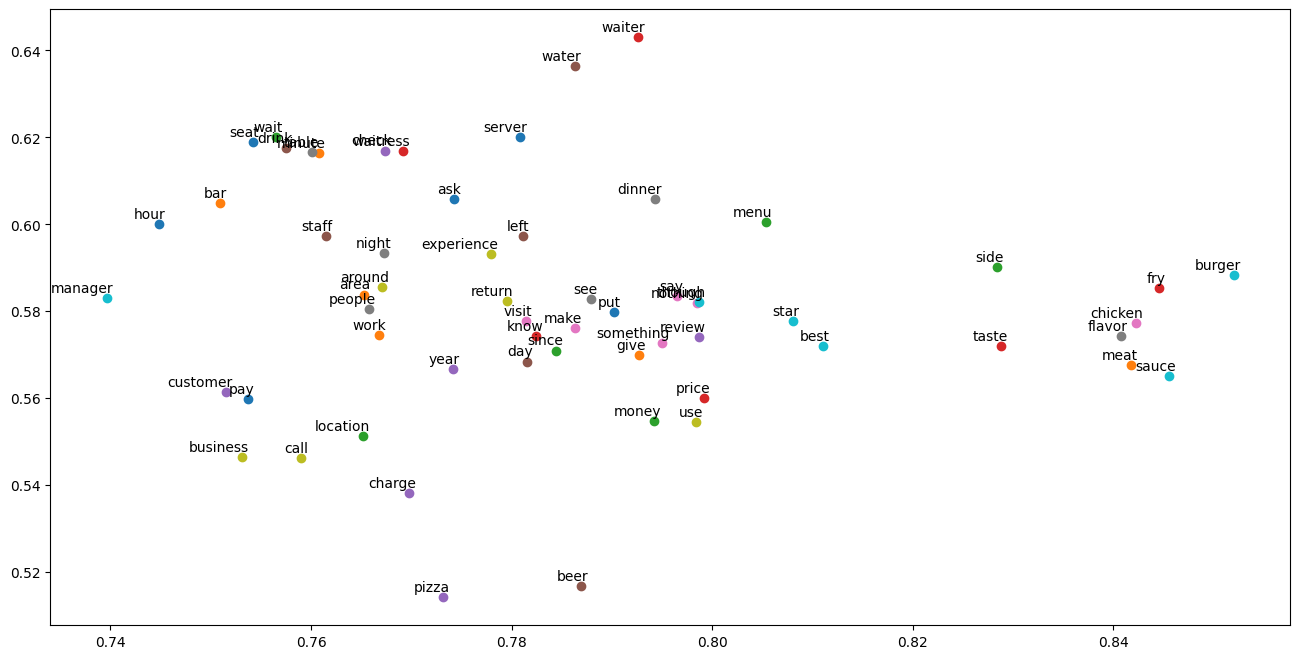

In [55]:
display_tsne_plot(model_W2V)

On peut voir que les mots sont regroupés par thème puisque faisant intervenir le sens du mot : 
 - sauce, meat, chiken, flavor sont situés au même endroit car font références à la nourriture
 - check, wait, seat, minute, table : font références au service

Encore une fois, cela nous donne une bonne idée des thèmes que nous pourrons avoir à la fin de notre étude.

## Détection par LDA et NMF

Pour détecter les thèmes principaux dans nos reviews, nous avons testé 2 algorithmes : 
 - Latent Dirichlet Allocation (LDA) ayant une approche probabiliste. Les mots sont initialement assignés de manière aléatoire aux thèmes. A chaque itération, les mots sont réassignés en ajustant leurs probabilités en fonction des distributions des thèmes et des mots. Le but est de tendre vers une meilleure cohérence.
 - Negative Matrix Factorisation (NMF) ayant une approche non probabiliste. Calcule 2 matrices, l’une représente l’importance de chaque thème dans chaque review, l’autre représente la contribution de chaque mot à chaque thème.

Ce dernier est très efficace quand une review parle majoritairement d’un seul topic. Mais nos reviews peuvent parler de plusieurs sujets en même temps puisque le client peut vraisemblablement parler de tout ce qu'il a sur le coeur.

In [56]:
# détection et affichage pour LDA
for n_topics in [10, 15, 20]:
    print("-"*70)
    print("Compute", n_topics, "topics...")
    display_lda(tfidf_mat, features_names, n_topics)

----------------------------------------------------------------------
Compute 10 topics...


Topic01   Topic02    Topic03 Topic04 Topic05    Topic06 Topic07 Topic08   
0  anything     least  appetizer     use  minute       seat     egg    room  \
1      item      half       year   steak    make        fry    give    left   
2     price      call   employee   water    wait        let     sat   night   
3     every  business    manager    want  people  something  change     day   
4   brought  sandwich    thought     lot   pizza       meat  dinner   phone   

      Topic09 Topic10  
0        feel     min  
1         say   visit  
2  experience    love  
3        bill    care  
4       serve     see

----------------------------------------------------------------------
Compute 15 topics...


Topic01 Topic02   Topic03 Topic04 Topic05   Topic06  Topic07  Topic08   
0     tell    year     staff  burger   money     drink    steak  manager  \
1  brought  waiter       day     lot    wait     sauce   dinner     care   
2    price   bland   chicken   party    seat  sandwich   shrimp     left   
3     hour    call  waitress   plate    menu     visit  without   flavor   
4      min  return  employee     egg    side      roll   change     room   

      Topic09  Topic10    Topic11 Topic12   Topic13 Topic14    Topic15  
0    location      fry       taco    work     since    need     cooked  
1  experience     know       meat     ask  business  minute    thought  
2       taste  quality      serve   start     lunch   pizza  appetizer  
3         say      see        end   phone      want    item      water  
4        star     area  something    bill      back    best        guy

----------------------------------------------------------------------
Compute 20 topics...


Topic01 Topic02 Topic03  Topic04  Topic05   Topic06  Topic07 Topic08   
0      ask    line    year   burger   change  sandwich  without     end  \
1      let    hour  coffee  manager  thought      roll    money   night   
2  brought   salad   plate  chicken   though    charge   dinner     bar   
3    price    call    work    visit  quality     start     make    left   
4     year    year     egg    serve     year  employee      sat    item   

  Topic09 Topic10   Topic11 Topic12     Topic13 Topic14 Topic15   Topic16   
0    bill   think  anything   drink        give   every    area      item  \
1  people    tell       day    back        best    love    wait     taste   
2   check     see   nothing   lunch         put  review    room  customer   
3   party   least    waiter   phone  everything    year     guy       lot   
4     say   point      item   steak        want    hour    star    cooked   

    Topic17    Topic18 Topic19   Topic20  
0   someone       beer    walk    server  
1  waitress       seat     use       pay  
2      know  appetizer    half     pizza  
3      taco      owner    home      menu  
4     sauce        min    year  location

In [57]:
# détection et affichage pour NMF
for n_topics in [10, 15, 20]:
    print("-"*70)
    print("Compute", n_topics, "topics...")
    display_nmf(tfidf_mat, features_names, n_topics)

----------------------------------------------------------------------
Compute 10 topics...


Topic01 Topic02 Topic03 Topic04  Topic05 Topic06   Topic07    Topic08   
0        work  waiter     pay    give    owner   check  employee     shrimp  \
1  everything  coffee    item     see     make   visit     pizza       meat   
2         min    beer  charge   taste     back   staff   quality   waitress   
3         say     lot   salad   table  without    seat     plate  appetizer   
4        call  around     ask    hour      end   lunch     start      water   

    Topic09   Topic10  
0     sauce     money  
1    server     every  
2      area      feel  
3      rice  anything  
4  location    review

----------------------------------------------------------------------
Compute 15 topics...


Topic01 Topic02 Topic03 Topic04  Topic05   Topic06   Topic07   Topic08   
0     pay    beer    seat   plate   change      need     night      home  \
1  coffee    rice  flavor    roll  chicken  anything     owner     money   
2    feel    bill  minute  review    think      want       lot  waitress   
3    make   lunch  server   start    sauce     check  employee  customer   
4    year    tell     egg   drink     room    burger       end       put   

  Topic09  Topic10 Topic11   Topic12    Topic13     Topic14  Topic15  
0   least     love    line    though  something         day    phone  
1     let  manager    make    around       left       every  thought  
2     sit  quality   price  sandwich        bar        work   people  
3  charge   cooked    give     point     dinner  experience     call  
4   pizza   shrimp   staff      know        min        hour     back

----------------------------------------------------------------------
Compute 20 topics...


Topic01 Topic02  Topic03  Topic04   Topic05 Topic06     Topic07   
0  customer  around      say  thought       end  change      waiter  \
1       pay   night    sauce     make  business    call       plate   
2   nothing     egg    drink    bland       day    room        area   
3      work   start  quality    salad     salad    year       start   
4      best    item     seat    drink    dinner    hour  experience   

     Topic08  Topic09   Topic10   Topic11   Topic12    Topic13     Topic14   
0     charge    taste     staff     owner    cooked      party         bar  \
1  appetizer    money  sandwich   without      tell      water      people   
2     coffee    since       ask       see     point  something        back   
3       wait  manager     steak  waitress  employee        let        bill   
4       best     item      care     check  anything        fry  everything   

   Topic15   Topic16 Topic17  Topic18 Topic19 Topic20  
0  someone  location    feel   minute    beer     sit  
1     left     least    meat     need  review    give  
2  chicken       lot  dinner     menu   pizza  flavor  
3     taco      walk   lunch  brought   table    star  
4    check       use  though     home     egg     put

## Détection par LDA Gensim

L'algorithme LDA semble plus prometteur. Nous le choisissons donc en utlisant le framework Gensim. Il nous permet notamment d'utiliser la méthode GridSearch pour optimiser les résultats en modifiant les paramètres d'entrée.

In [58]:
# paramètres à tester pour l'optimisation
param_grid = {
    'num_topics': [5, 7, 10, 15, 20],
    'passes': [20, 30, 40]
}

In [59]:
results = []
best_model = None
best_coherence_score = -1
best_list_model = {}

for params in ParameterGrid(param_grid):
    if not best_list_model.get(params["num_topics"], False):
        best_list_model[params["num_topics"]] = (None, -1)
    # Entraînement du modèle LDA avec les paramètres donnés
    lda_model = LdaModel(corpus=corpus_gensim, id2word=dictionary, random_state=42, **params)
    
    # Calcul de la cohérence des sujets
    coherence_model = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    # Stockage des résultats
    results.append((params, coherence_score))
    if coherence_score > best_list_model[params["num_topics"]][1]:
        best_list_model[params["num_topics"]] = (lda_model, coherence_score)
    
    # Mise à jour du meilleur modèle si le score de cohérence est plus élevé
    if coherence_score > best_coherence_score:
        best_model = lda_model
        best_coherence_score = coherence_score    

Ce qui nous permet d'obtenir le résultat le plus optimal avec un score de cohérence le plus élevé possible.

In [60]:
# Affichage du meilleur modèle et de son score de cohérence
print("Meilleur modèle :")
print(best_model)
print("Score de cohérence des sujets :", best_coherence_score)

print("\n", "=====================================", "\n")

# Affichage des thèmes pour best_model
topics = best_model.print_topics(num_topics=20, num_words=5)
for topic in topics:
    print(topic)

Meilleur modèle :
LdaModel<num_terms=114, num_topics=7, decay=0.5, chunksize=2000>
Score de cohérence des sujets : 0.49620218388859794


(0, '0.101*"call" + 0.100*"wait" + 0.095*"hour" + 0.074*"location" + 0.054*"minute"')
(1, '0.072*"burger" + 0.056*"salad" + 0.053*"fry" + 0.042*"sandwich" + 0.039*"lunch"')
(2, '0.059*"taste" + 0.055*"day" + 0.054*"bar" + 0.048*"water" + 0.047*"coffee"')
(3, '0.073*"chicken" + 0.062*"taste" + 0.054*"meat" + 0.054*"sauce" + 0.044*"rice"')
(4, '0.074*"minute" + 0.059*"drink" + 0.049*"server" + 0.048*"ask" + 0.047*"wait"')
(5, '0.150*"pizza" + 0.110*"price" + 0.064*"quality" + 0.056*"item" + 0.053*"menu"')
(6, '0.073*"customer" + 0.042*"people" + 0.040*"work" + 0.037*"business" + 0.037*"employee"')


J’ai repéré que certains topics peuvent être regroupés en 3 thèmes : 
 - ce qui touche au temps et à la réservation
 - ce qui touche à l’alimentation, la nourriture et les boissons
 - ce qui touche à la gestion du restaurant et à la relation client

A l'aide du framework pyLDAvis, nous pouvons également en faire une représentation graphique pertinente pour notre analyse.

In [1]:
# # représentation graphique de la détection par LDA
# model = LdaModel(corpus=corpus_gensim, id2word=dictionary, num_topics=7, passes=20, random_state=42)
# lda_display = ldavis_gen.prepare(model, corpus_gensim, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display)

Le temps et la réservation sont situés sur la gauche avec des mots comme call, hour, phone, seat et table.  
La nourriture et les boissons sont situés en bas à droite avec des mots tels que coffee, meat, rice, burger et salad.  
Et enfin, tout ce qui porte sur la gestion du restaurant et la relation client est en haut avec les mots employee, customer, business, price et quality.

# Volet III : Labellisation automatique des photos postées

## Préparation du dataset d'étude

De la même manière et pour les mêmes raisons que précédemment, nous allons opter pour le framework dask. On charge alors le fichier csv des photos par son intermédiaire.

In [62]:
photos = dd.read_json("yelp_photos/photos.json",lines = True, encoding = 'utf-8', blocksize="100MB")

In [63]:
photos.head()

photo_id             business_id   
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA  \
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2  vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3  pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4  H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   

                                             caption    label  
0  Nice rock artwork everywhere and craploads of ...   inside  
1                                                     outside  
2                                     oyster shooter    drink  
3                                      Shrimp scampi     food  
4                                                        food

On récupère les photos uniquement reliées aux restaurants.

In [64]:
restaurant_photos = photos.loc[photos["business_id"].isin(restaurant_data["business_id"]), :]
restaurant_photos = restaurant_photos.drop(columns=["business_id", "caption"])

On affiche la proportion de chaque catégorie de photo dans l'ensemble du dataset des restaurants.

%  %_cumul
label                  
food     58.14    58.14
inside   25.70    83.84
outside   8.70    92.54
drink     6.61    99.15
menu      0.85   100.00

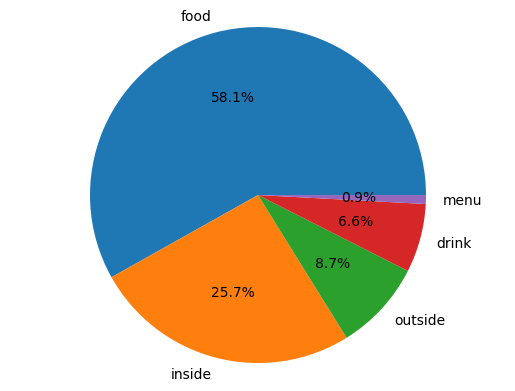

In [65]:
limit_perc = 0.5
res = show_unique_values(restaurant_photos, "label")

On peut voir que la proportion est très différente d'une catégorie à l'autre. Cependant, nous en avons assez pour avoir 200 photos de chaque catégorie.

In [66]:
photos_sample = restaurant_photos.groupby(['label']).apply(pd.DataFrame.sample, n=200, replace=True, random_state=42).reset_index(drop=True)
photos_sample = photos_sample.compute()

In [67]:
print("On obtient donc une liste de photos de", photos_sample.shape[0], "lignes. Ce qui correspond bien à 200 photos fois 5 catégories.")

On obtient donc une liste de photos de 1000 lignes. Ce qui correspond bien à 200 photos fois 5 catégories.


In [68]:
list_photos = photos_sample["photo_id"].values.tolist()

## Afficher des images aléatoirement de chaque catégorie

------------------------------ FOOD ------------------------------


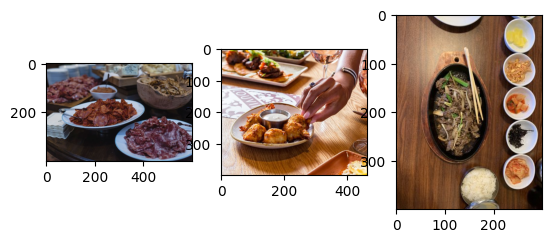

------------------------------ INSIDE ------------------------------


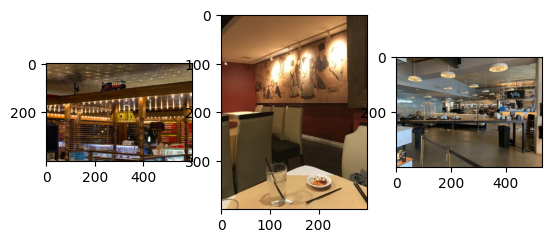

------------------------------ OUTSIDE ------------------------------


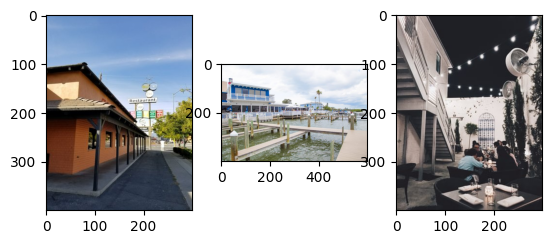

------------------------------ DRINK ------------------------------


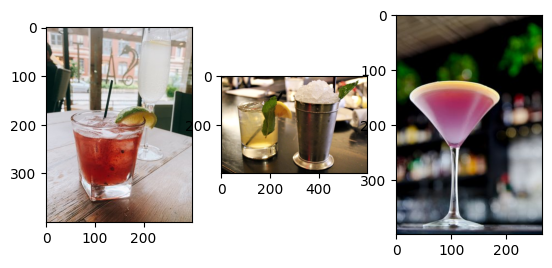

------------------------------ MENU ------------------------------


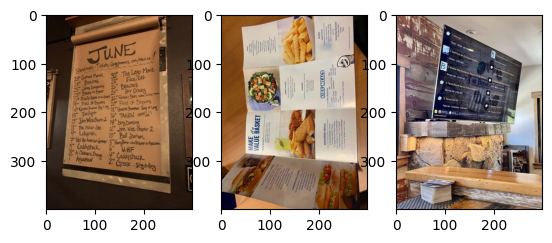

In [69]:
list_labels = ["food", "inside", "outside", "drink", "menu"]

for name in list_labels :
    print("-"*30, name.upper(), "-"*30)
    temp_labeled_photos = photos_sample.loc[photos_sample["label"] == name, :].reset_index(drop=True)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        name = temp_labeled_photos.iloc[i, 0]
        img_path = os.path.join("yelp_photos/photos", f"{name}.jpg")
        image = imread(img_path)
        plt.imshow(image)
    plt.show()

## Etapes du preprocessing pour une image

Voici les différentes étapes de preprocessing pour l'analyse d'images : 
 - le chargement de l'image brute
 - la conversion en noir et blanc pour avoir un seul canal de niveau de gris au lieu de 3 canaux de couleur RGB (réduction de dimension)
 - le filtrage du bruit pour obtenir des images non dégradées
 - l'égalisation de l'histogramme de l'image pour permettre d'améliorer le contraste de l'image
 - l'extraction des descripteurs de l'image qui sont les points remarquables, ie, contours et coins

Compute SIFT model to the picture ahM2Rv7NBGUQGUlCClLYZw.jpg


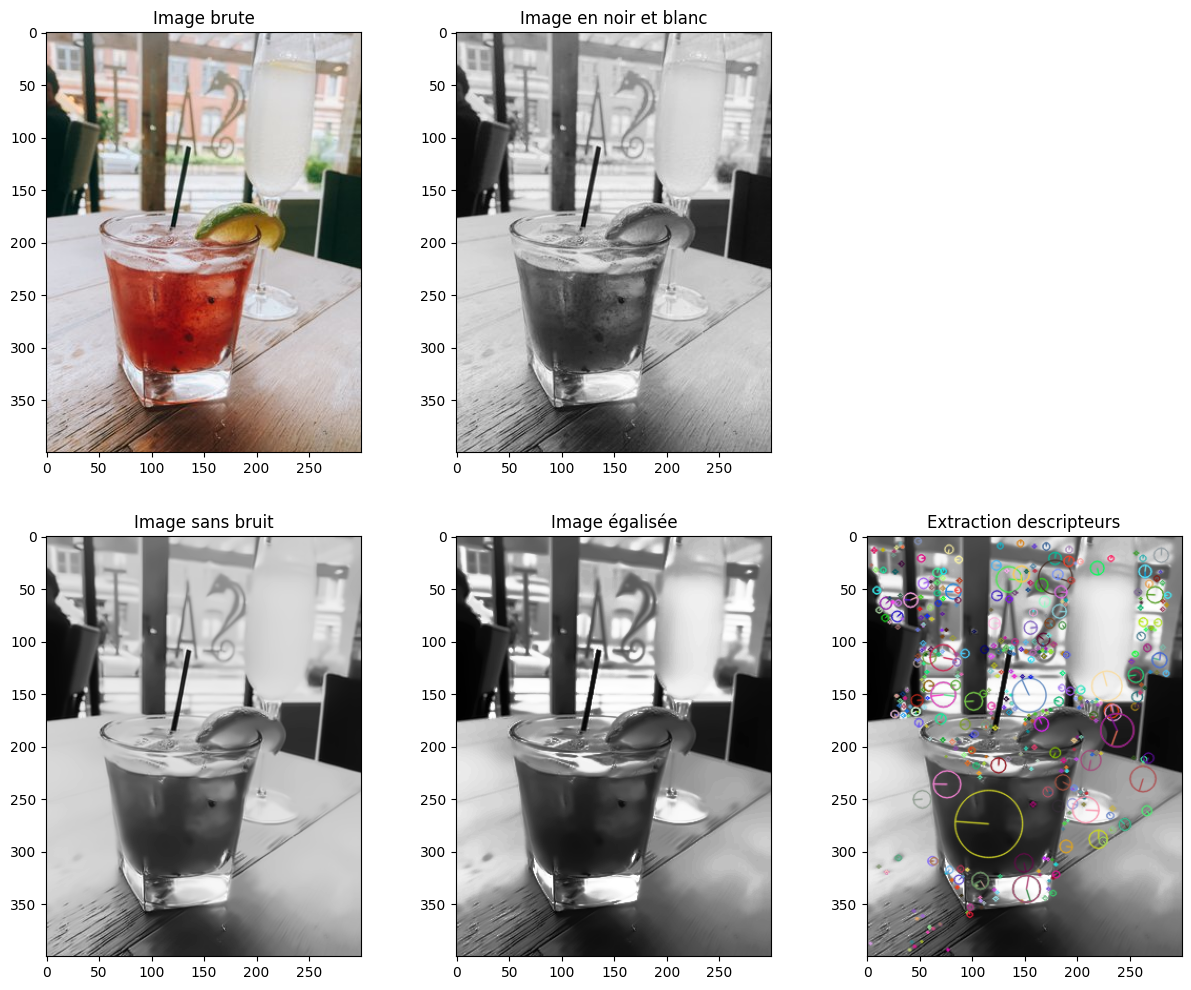

In [70]:
photo_name = "yelp_photos/photos/" + list_photos[0] + ".jpg"
image = extract_descriptors_from_single_photo(photo_name, model_name="SIFT")

## Analyse non supervisée (SIFT & ORB)

Nous allons donc effectuer tous les traitements dont on a parlé juste au dessus à l'ensemble des images de notre échantillon pour arriver à les classer de manière non supervisée. Pour cela, nous allons utiliser 2 algorithmes SIFT et ORB.

Nombre de descripteurs :  (450168, 128)
Temps de traitement SIFT descriptor :            73.20 secondes
Nombre de clusters estimés :  671
Création de 671 clusters de descripteurs ...
temps de traitement kmeans :             5.77 secondes
temps de création histogrammes :             0.71 secondes
Dimensions dataset avant réduction PCA :  (1000, 671)
Dimensions dataset après réduction PCA :  (1000, 532)
ARI :  0.1574471601034349


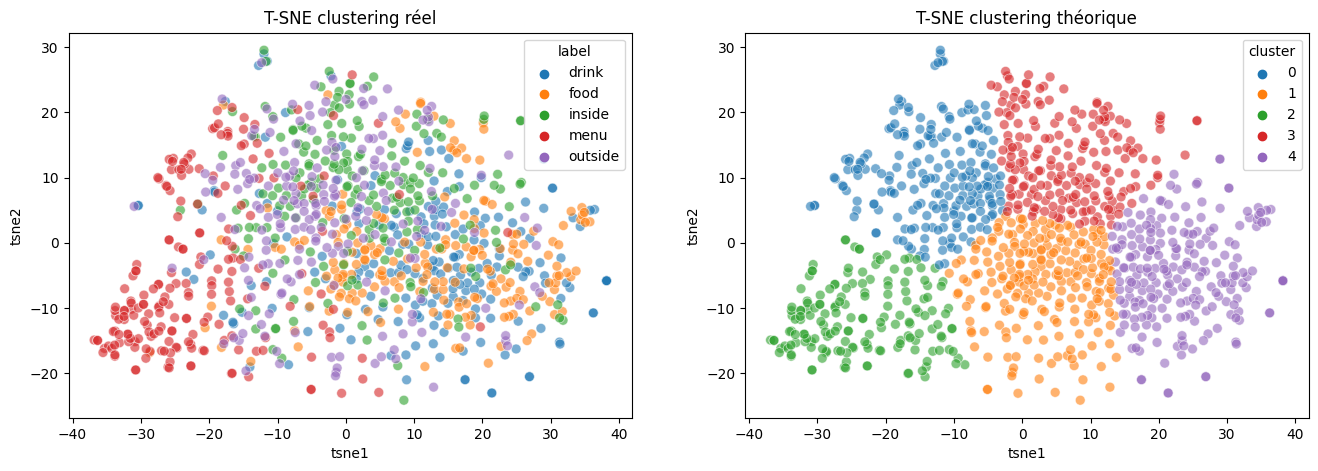

Best score so far : (('food', 'inside', 'outside', 'drink', 'menu'), 0.094)
Best score so far : (('food', 'inside', 'outside', 'menu', 'drink'), 0.149)
Best score so far : (('food', 'inside', 'menu', 'outside', 'drink'), 0.306)
Best score so far : (('food', 'outside', 'menu', 'inside', 'drink'), 0.348)
Best score so far : (('inside', 'food', 'menu', 'outside', 'drink'), 0.383)
Best score so far : (('outside', 'food', 'menu', 'inside', 'drink'), 0.43)
Calcul et affichage de la matrice de confusion


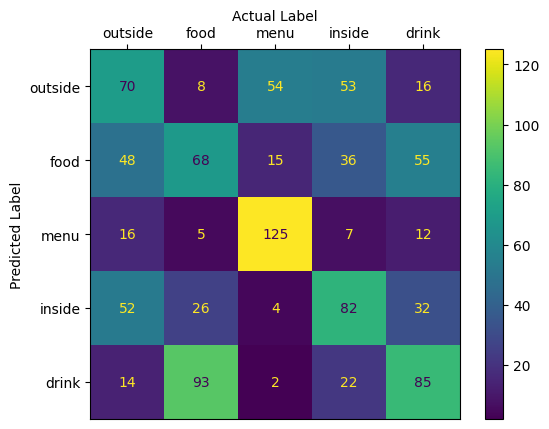

Calcul et affichage du rapport de classification
              precision    recall  f1-score   support

       drink       0.39      0.42      0.41       200
        food       0.31      0.34      0.32       200
      inside       0.42      0.41      0.41       200
        menu       0.76      0.62      0.68       200
     outside       0.35      0.35      0.35       200

    accuracy                           0.43      1000
   macro avg       0.44      0.43      0.44      1000
weighted avg       0.44      0.43      0.44      1000

Nombre de descripteurs :  (490364, 32)
Temps de traitement ORB descriptor :            62.09 secondes
Nombre de clusters estimés :  700
Création de 700 clusters de descripteurs ...
temps de traitement kmeans :             4.59 secondes
temps de création histogrammes :             0.58 secondes
Dimensions dataset avant réduction PCA :  (1000, 700)
Dimensions dataset après réduction PCA :  (1000, 587)
ARI :  0.046367795791584863


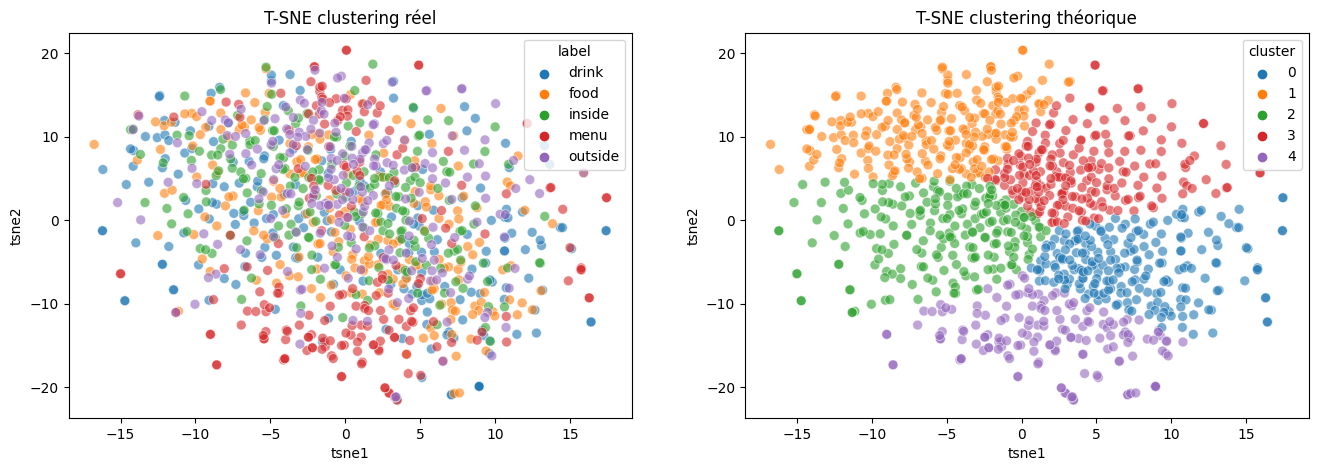

Best score so far : (('food', 'inside', 'outside', 'drink', 'menu'), 0.267)
Best score so far : (('food', 'inside', 'drink', 'outside', 'menu'), 0.319)
Calcul et affichage de la matrice de confusion


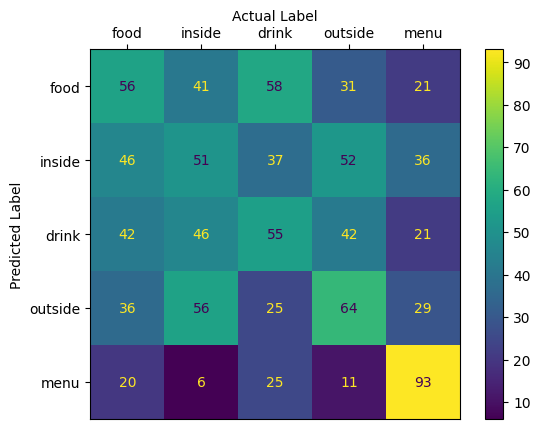

Calcul et affichage du rapport de classification
              precision    recall  f1-score   support

       drink       0.27      0.28      0.27       200
        food       0.27      0.28      0.28       200
      inside       0.23      0.26      0.24       200
        menu       0.60      0.47      0.52       200
     outside       0.30      0.32      0.31       200

    accuracy                           0.32      1000
   macro avg       0.33      0.32      0.32      1000
weighted avg       0.33      0.32      0.32      1000



In [71]:
for mod in ["SIFT", "ORB"]:
    # searching for descriptors part
    model_keypoints_by_img, model_keypoints_all = extract_descriptors(mod, list_photos)
    trained_kmeans = cluster_descriptors(model_keypoints_all, nb_categ=5, meth_nd_clusters="sqrt")
    im_features = create_histograms_from_keypoints(model_keypoints_by_img, trained_kmeans)
    feat_pca = reducing_by_pca(im_features)

    # display t-SNE graph part
    df_tsne, X_tsne = compute_tsne(photos_sample, feat_pca)
    df_tsne = clustering_from_tsne_data(photos_sample, df_tsne, X_tsne)
    # display_tsne_plot(df_tsne, "label")
    display_tsne_plot_dbl(df_tsne, "label", "cluster")

    # confusion matrix part
    df_tsne, best_res = find_corresponding_labels(df_tsne, list_labels)
    display_confusion_matrix(actual_class=df_tsne["label"], predict_class=df_tsne["cluster_name"], display_labels=best_res[0])
    display_classification_report(actual_class=df_tsne["label"], predict_class=df_tsne["cluster_name"])

Comme on peut le voir, les 2 algorithmes semble avoir du mal à détecter correctement les catégories.
||SIFT|ORB|
|--|--|--|
|ARI-Score|0.157|0.046|
|Accuracy|0.430|0.319|

Le ARI-Score est très bas. Cela se reflète dans les représentations t-SNE puisque les catégories sont très mélangées. On peut uniquement distinguer les menus avec SIFT.  
Par ailleurs, les matrices de confusion ont des correspondances théoriques puisque j'ai choisi celles qui donnent l'accuracy la plus élevée.  
Nous sommes donc limités par cette approche. Nous allons donc en utiliser une nouvelle, le Transfer Learning.

## Analyse non supervisée Transfer Learning (TL)

Le principe est simple, utiliser un modèle préalablement entraîné. J’ai choisi le modèle VGG16 qui a été entraîné sur 14 millions d’images de 1000 catégories différentes. Il s’agit d’un réseau de neurones très fréquemment utilisé en reconnaissance d’image.  
A partir de là, on supprime la dernière couche qui traduit les données de sortie en classification de l’image. Le modèle restant permet d’obtenir directement les features de nos images.

In [72]:
model_keypoints_by_img, model_keypoints_all = extract_descriptors_cnn(list_photos)

2023-06-21 13:02:37.893058: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/slerendu/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-06-21 13:02:37.893072: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-21 13:02:37.893083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sle-machina): /proc/driver/nvidia/version does not exist
2023-06-21 13:02:37.893789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appro

0
100
200
300
400
500
600
700
800
900
Nombre de descripteurs :  (1000, 25088)
Temps de traitement CNN VGG16 descriptor :           108.26 secondes


Avec ces features qui caractérisent nos images, on va maintenant faire le même traitement que précédemment en passant par de la réduction et une représentation t-SNE.  
Cependant, nous allons tester d'une part avec une réduction par PCA et d'autre part, sans réduction par PCA. A la fin, nous comparerons les résultats.

### Analyse non supervisée TL avec rduction par PCA

Dimensions dataset avant réduction PCA :  (1000, 25088)
Dimensions dataset après réduction PCA :  (1000, 919)
ARI :  0.3904312043276365


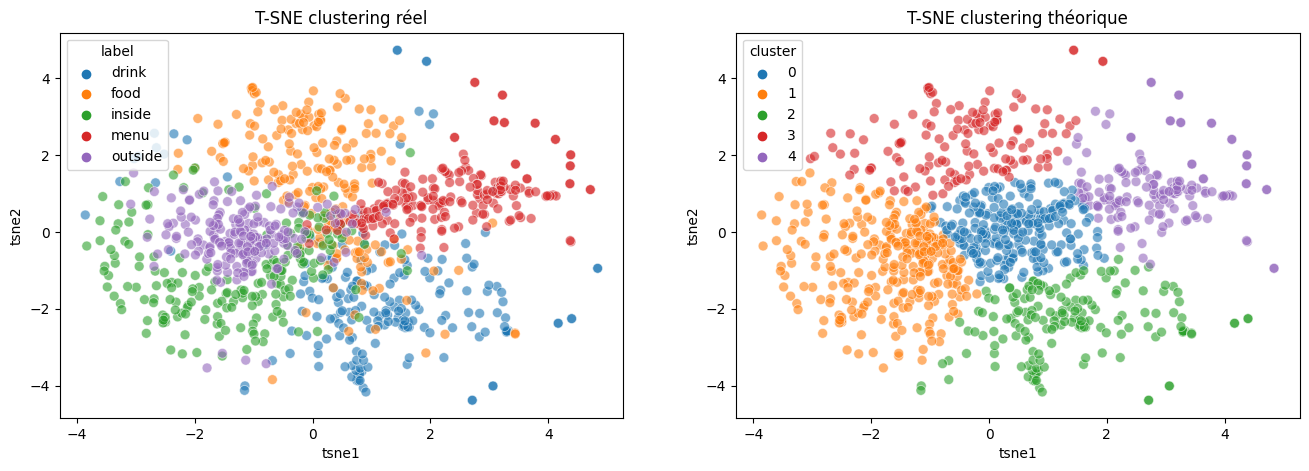

Best score so far : (('food', 'inside', 'outside', 'drink', 'menu'), 0.362)
Best score so far : (('food', 'inside', 'drink', 'outside', 'menu'), 0.496)
Best score so far : (('food', 'outside', 'drink', 'inside', 'menu'), 0.506)
Best score so far : (('inside', 'outside', 'drink', 'food', 'menu'), 0.592)
Calcul et affichage de la matrice de confusion


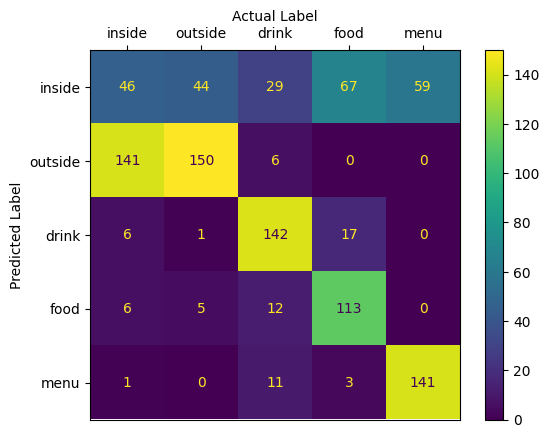

Calcul et affichage du rapport de classification
              precision    recall  f1-score   support

       drink       0.86      0.71      0.78       200
        food       0.83      0.56      0.67       200
      inside       0.19      0.23      0.21       200
        menu       0.90      0.70      0.79       200
     outside       0.51      0.75      0.60       200

    accuracy                           0.59      1000
   macro avg       0.66      0.59      0.61      1000
weighted avg       0.66      0.59      0.61      1000



In [73]:
feat_pca = reducing_by_pca(model_keypoints_all)

# display t-SNE graph part
df_tsne, X_tsne = compute_tsne(photos_sample, feat_pca)
df_tsne = clustering_from_tsne_data(photos_sample, df_tsne, X_tsne)
display_tsne_plot_dbl(df_tsne, "label", "cluster")

# confusion matrix part
df_tsne, best_res = find_corresponding_labels(df_tsne, list_labels)
display_confusion_matrix(actual_class=df_tsne["label"], predict_class=df_tsne["cluster_name"], display_labels=best_res[0])
display_classification_report(actual_class=df_tsne["label"], predict_class=df_tsne["cluster_name"])

### Analyse non supervisée TL avec rduction sans PCA

ARI :  0.4183072652691097


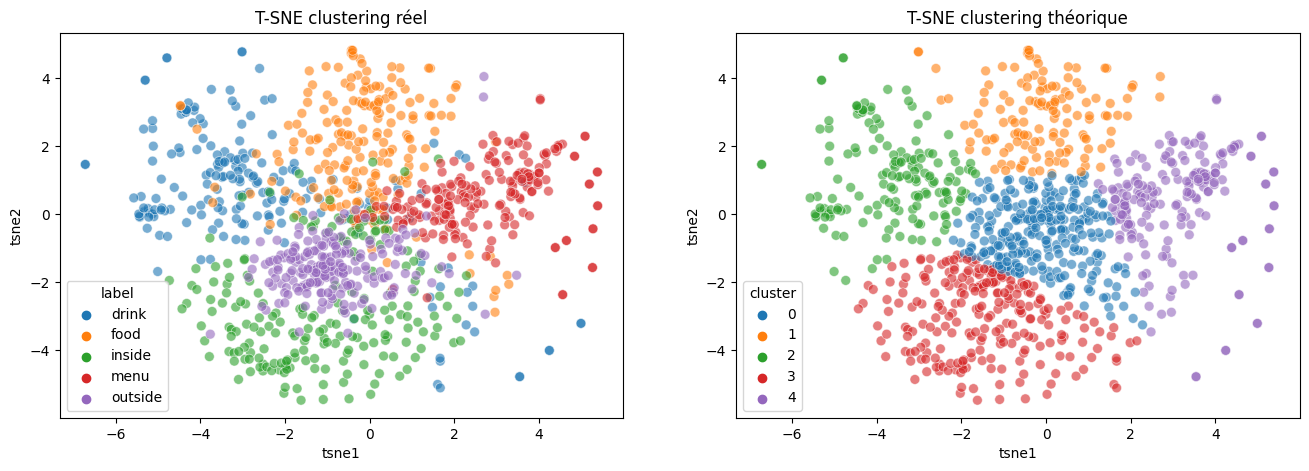

Best score so far : (('food', 'inside', 'outside', 'drink', 'menu'), 0.228)
Best score so far : (('food', 'inside', 'drink', 'outside', 'menu'), 0.455)
Best score so far : (('food', 'outside', 'drink', 'inside', 'menu'), 0.511)
Best score so far : (('inside', 'food', 'drink', 'outside', 'menu'), 0.568)
Best score so far : (('outside', 'food', 'drink', 'inside', 'menu'), 0.685)
Calcul et affichage de la matrice de confusion


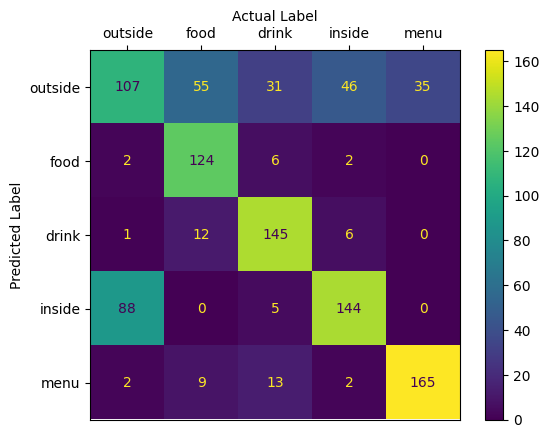

Calcul et affichage du rapport de classification
              precision    recall  f1-score   support

       drink       0.88      0.72      0.80       200
        food       0.93      0.62      0.74       200
      inside       0.61      0.72      0.66       200
        menu       0.86      0.82      0.84       200
     outside       0.39      0.54      0.45       200

    accuracy                           0.69      1000
   macro avg       0.73      0.68      0.70      1000
weighted avg       0.73      0.69      0.70      1000



In [74]:
# sans réduction par PCA

# display t-SNE graph part
df_tsne, X_tsne = compute_tsne(photos_sample, model_keypoints_all)
df_tsne = clustering_from_tsne_data(photos_sample, df_tsne, X_tsne)
display_tsne_plot_dbl(df_tsne, "label", "cluster")

# confusion matrix part
df_tsne, best_res = find_corresponding_labels(df_tsne, list_labels)
display_confusion_matrix(actual_class=df_tsne["label"], predict_class=df_tsne["cluster_name"], display_labels=best_res[0])
display_classification_report(actual_class=df_tsne["label"], predict_class=df_tsne["cluster_name"])

### Comparaison résultats TL

Comme on peut le voir, le Transfer Learning est bien plus efficace que SIFT et ORB.
||VGG16 w PCA|VGG16 wo PCA|SIFT|
|--|--|--|--|
|ARI-Score|0.390|0.418|0.157|
|Accuracy|0.592|0.685|0.430|

Le ARI-Score est nettement plus élevé. Cela se reflète dans les représentations t-SNE puisque les catégories se distinguent plus les unes des autres.

Par ailleurs, les matrices de confusion nous donnent de bien meilleurs résultats étant donné l'ARI-Score. On noter juste la confusion entre les photos inside and outside puisque qu'il s'agit de catégories similaires. En effet, elles représentent toutes 2 le décor. A contrario, les photos de menu sont les mieux détectées puisque l'on peut observer du texte contrairement aux autres catégories.